## Driver code comparing output of different preproc pipelines 
- Note: currently using output after atlas-based grouping
- Atlas used: aparc (Freesurfer) DKT-31 Mindboggle (ANTs: https://mindboggle.readthedocs.io/en/latest/labels.html) 

### Steps
- import data csvs 
- visualize data distributions 
- correlate features across pipelines
- compare performance of machine-learning model (scikit-learn)
- compare performance of statsmodels (ols or logit)

In [1]:
import sys
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn3
import time


from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

sys.path.append('../')
from lib.data_handling import *
from lib.data_stats import *

### Data paths

In [2]:
proj_dir = '/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/'
#proj_dir = '/Users/nikhil/projects/compare-surf-tools/'
data_dir = proj_dir + 'data/'
fs60_dir = data_dir + 'fs60_group_stats/'
qc_dir =  '/home/nikhil/projects/CT_reproduce/data/QC/'
outlier_dir = data_dir + 'outliers/'
results_dir = data_dir + 'results/'

demograph_file = 'ABIDE_Phenotype.csv'
dkt_roi_names = '/DKT/DKT_parcel_map_FS_CIVET.csv'

ants_file = 'ABIDE_ants_thickness_data.csv' #uses modified (mindboggle) dkt atlas with 31 ROIs
civet_file = 'ABIDE_civet2.1_thickness.csv'

fs53_file = 'ABIDE_fs5.3_thickness.csv'
fs51_file = 'cortical_fs5.1_measuresenigma_thickavg.csv' 
fs60_lh_file = 'lh.aparc.thickness.table.test1' #'aparc_lh_thickness_table.txt' #'lh.aparc.thickness.table.test1'
fs60_rh_file = 'rh.aparc.thickness.table.test1' #'aparc_rh_thickness_table.txt' #'rh.aparc.thickness.table.test1'

manual_outlier_file = 'master_QC_table.csv'
pipeline_outlier_file = 'pipeline_outlier_data.csv'

### Global Vars

In [3]:
subject_ID_col = 'SubjID'

### Load data

In [4]:
# Demographics and Dx
demograph = pd.read_csv(data_dir + demograph_file)
demograph = demograph.rename(columns={'Subject_ID':subject_ID_col})

# ROI names
dkt_roi_map = pd.read_csv(data_dir + dkt_roi_names)

print('loading available datasets...\n')

# CIVET 2.1
civet_data = pd.read_csv(data_dir + civet_file, dtype={subject_ID_col: str})
print('shape of civet data {}'.format(civet_data.shape))
civet_data_std = standardize_civet_data(civet_data, subject_ID_col, dkt_roi_map)
print('shape of stdized civet data {}'.format(civet_data_std.shape))
print('')

# ANTs
ants_data = pd.read_csv(data_dir + ants_file, header=2)
print('shape of ants data {}'.format(ants_data.shape))
ants_data_std = standardize_ants_data(ants_data, subject_ID_col)
print('shape of stdized ants data {}'.format(ants_data_std.shape))
print('')

# FS
fs53_data = pd.read_csv(data_dir + fs53_file)
print('shape of fs53 data {}'.format(fs53_data.shape))
fs53_data_std = standardize_fs_data(fs53_data, subject_ID_col)
print('shape of stdized fs53 data {}'.format(fs53_data_std.shape))
print('')

fs51_data = pd.read_csv(data_dir + fs51_file)
print('shape of fs51 data {}'.format(fs51_data.shape))
fs51_data_std = standardize_fs_data(fs51_data, subject_ID_col)
print('shape of stdized fs51 data {}'.format(fs51_data_std.shape))
print('')

fs60_lh_data = pd.read_csv(fs60_dir + fs60_lh_file, delim_whitespace=True)
fs60_rh_data = pd.read_csv(fs60_dir + fs60_rh_file, delim_whitespace=True)
print('shape of fs60 data l: {}, r: {}'.format(fs60_lh_data.shape,fs60_rh_data.shape))

fs60_data_std = standardize_fs60_data(fs60_lh_data, fs60_rh_data, subject_ID_col)
print('shape of stdized fs60 data {}'.format(fs60_data_std.shape))

loading available datasets...

shape of civet data (899, 65)
shape of stdized civet data (899, 65)

shape of ants data (1101, 99)
shape of stdized ants data (1101, 90)

shape of fs53 data (976, 74)
shape of stdized fs53 data (976, 74)

shape of fs51 data (1112, 74)
shape of stdized fs51 data (1112, 74)

shape of fs60 data l: (1047, 36), r: (1047, 36)
shape of left and right merge fs6.0 df (1047, 71)
shape of stdized fs60 data (1047, 71)


### Create master dataframe

In [5]:
data_dict = {'CIVET': civet_data_std,
            'ANTs' : ants_data_std,
            'FS6.0' : fs60_data_std,
            'FS5.3' : fs53_data_std,
            'FS5.1' : fs51_data_std}

na_action = 'drop' # options: ignore, drop; anything else will not use the dataframe for analysis. 
master_df_raw, common_subs, common_roi_cols = combine_processed_data(data_dict, subject_ID_col, na_action)

# Add demographic columns to the master_df_raw
useful_demograph = demograph[[subject_ID_col,'SEX','AGE_AT_SCAN','DX_GROUP','SITE_ID']].copy()

# DX_GROUP: (orginal: 1:ASD, 2:Controls) 
# Replace to (2 with 0 for statsmodels) (1:ASD, 0:Controls)
useful_demograph['DX_GROUP'] = useful_demograph['DX_GROUP'].replace({2:0})
useful_demograph['SEX'] = useful_demograph['SEX']-1
_,useful_demograph[subject_ID_col] = useful_demograph[subject_ID_col].str.rsplit('_', 1).str

master_df_raw = pd.merge(master_df_raw, useful_demograph, how='left', on=subject_ID_col)

print('\nmaster df shape after adding demographic info {}'.format(master_df_raw.shape))
print('\nNumber of common subjects {}({}), ROIs {}'.format(len(common_subs), master_df_raw[master_df_raw['pipeline']=='fs60']['DX_GROUP'].value_counts().to_dict(),len(common_roi_cols)))


Number of datasets: 5
Finding common subject and columns
dataset : FS6.0
common subs: 1047
dataset : FS5.3
common subs: 942
dataset : ANTs
common subs: 941
dataset : CIVET
common subs: 778
dataset : FS5.1
common subs: 778
Number of common subjects and columns: 778, 63

checking FS6.0 dataframe
Shape of the dataframe based on common cols and subs (778, 63)
Basic data check passed
Shape of the concat dataframe (778, 64)

checking FS5.3 dataframe
Shape of the dataframe based on common cols and subs (778, 63)
Basic data check passed
Shape of the concat dataframe (1556, 64)

checking ANTs dataframe
Shape of the dataframe based on common cols and subs (778, 63)
Basic data check passed
Shape of the concat dataframe (2334, 64)

checking CIVET dataframe
Shape of the dataframe based on common cols and subs (778, 63)
Basic data check passed
Shape of the concat dataframe (3112, 64)

checking FS5.1 dataframe
Shape of the dataframe based on common cols and subs (778, 63)
Basic data check passed
Shap

### Basic demographic distributions

Dataframe shape: (778, 68)


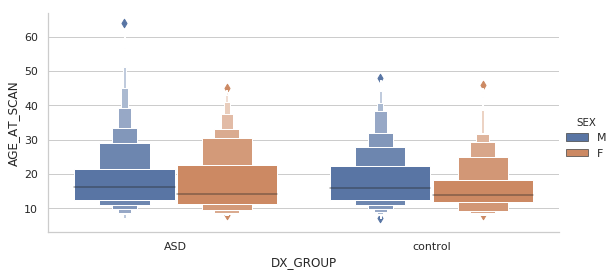

In [6]:
plot_df = master_df_raw[master_df_raw['pipeline']=='ANTs'].copy()
print('Dataframe shape: {}'.format(plot_df.shape))
plot_df['DX_GROUP'] = plot_df['DX_GROUP'].replace({0:'control', 1:'ASD'})
plot_df['SEX'] = plot_df['SEX'].replace({0:'M', 1:'F'})

sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y='AGE_AT_SCAN',x='DX_GROUP',hue='SEX',data=plot_df,
                    aspect=2,height=4,kind='boxen')

### QC filters
- Manual (Gleb or Maarten)
- Automatic (Amadou) 
- Ringing subs: ['0050197',0050211','0050049','0051160','0050815','0050418','0050422','0050423','0050309','0050283','0050313','0050323','0051353','0051352','0051334']

In [7]:
# Dictionary allow iterating and QC comparisons later
# Default master_df is without QC
qc_list = ['No_QC','manual_maarten','manual_gleb','auto']
master_df_dict = {}
n_workflow = len(master_df_raw['pipeline'].unique())
outlier_df = pd.DataFrame(index=master_df_raw[subject_ID_col].unique())
for qc in qc_list:
    if qc == 'No_QC':
        print('No QC applied')
        filtered_df = master_df_raw
        filtered_subs = filtered_df[subject_ID_col].unique()
        print('Resultant number of subjects {}'.format(len(filtered_subs)))
    else:            
        if qc == 'manual_maarten':
            qc_df = pd.read_csv(qc_dir + manual_outlier_file, dtype={'SubjID': int})
            qc_criterion = ('QC_maarten',[0]) # keep subs
        elif qc == 'manual_gleb':
            qc_df = pd.read_csv(qc_dir + manual_outlier_file, dtype={'SubjID': int})
            qc_criterion = ('QC_gleb',['1','-+1']) # keep subs
        elif qc == 'auto':
            qc_df_long = pd.read_csv(outlier_dir + pipeline_outlier_file,dtype={'SubjID': int})
            qc_df = qc_df_long.pivot(index=subject_ID_col,columns='pipeline',values='outlier_ind')
            qc_df.apply(pd.to_numeric)
            #keep only if a subject is not an outlier in any of the pipelines
            qc_df['QC_outlier'] = qc_df[list(qc_df.columns)].sum(axis=1) 
            qc_df[subject_ID_col] = qc_df.index
            qc_criterion = ('QC_outlier',[0])    
        else:
            print('Unknow QC type')

        # Subjects you want to keep based on other crieria for sample size purposes
        external_criterion = {'SITE_ID':3*n_workflow}
        filtered_df = filter_data(master_df_raw, subject_ID_col, qc_df, qc_criterion, external_criterion)
        filtered_subs = filtered_df[subject_ID_col].unique()
        outlier_df[qc] = np.where(outlier_df.index.isin(filtered_subs),0,1)
        
    master_df_dict[qc] = filtered_df

master_df = master_df_dict['No_QC'] # Default

No QC applied
Resultant number of subjects 778

Filtering based on QC_maarten. Number subjects before filtering 778
Resultant number of subjects 748
Filtering based on external crierion
Performing min sample (N_min=15) per workflow size check based on SITE_ID
Dropping subjects for all workflows for SITE_ID Series([], Name: SITE_ID, dtype: int64)
Resultant number of subjects 748

Filtering based on QC_gleb. Number subjects before filtering 778
Resultant number of subjects 204
Filtering based on external crierion
Performing min sample (N_min=15) per workflow size check based on SITE_ID
Dropping subjects for all workflows for SITE_ID OLIN       15
MAX_MUN    15
UCLA_2     15
PITT        5
Name: SITE_ID, dtype: int64
Resultant number of subjects 194

Filtering based on QC_outlier. Number subjects before filtering 778
Resultant number of subjects 685
Filtering based on external crierion
Performing min sample (N_min=15) per workflow size check based on SITE_ID
Dropping subjects for all workf

Total number of subjects: 778

outlier overlap
                manual_maarten  manual_gleb  auto
manual_maarten              30           30     6
manual_gleb                 30          584    89
auto                         6           89    95


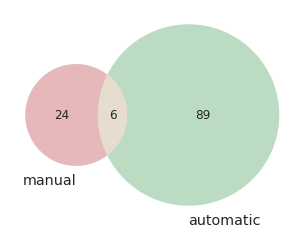

In [8]:
# Outlier comparisons
outlier_overlap = outlier_df.T.dot(outlier_df)
print('Total number of subjects: {}\n'.format(len(outlier_df)))
print('outlier overlap')
print(outlier_overlap)

# Venn diagrams
s1 = set(outlier_df[outlier_df['manual_maarten']==1].index)
s2 = set(outlier_df[outlier_df['manual_gleb']==1].index)
s3 = set(outlier_df[outlier_df['auto']==1].index)
v = venn2([s1,s3],set_labels = ('manual', 'automatic'))
#v = venn3([s1,s2,s3],set_labels = ('manual_maarten', 'manual_gleb', 'auto'))


### Correlation between pipelines

In [19]:
master_df = master_df_dict['auto']

possible_pairs = list(itertools.combinations(data_dict.keys(), 2))
xcorr_pairs_df = pd.DataFrame()
for pair in possible_pairs:
    pipe1 = pair[0]
    pipe2 = pair[1]
    for dx in [0,1]:
        df1 = master_df[(master_df['pipeline']==pipe1)&(master_df['DX_GROUP']==dx)][[subject_ID_col]+common_roi_cols]
        df2 = master_df[(master_df['pipeline']==pipe2)&(master_df['DX_GROUP']==dx)][[subject_ID_col]+common_roi_cols]
        xcorr_df = cross_correlations(df1,df2,subject_ID_col)
        xcorr_df['pipeline_pair'] = np.tile(str('{}-{}'.format(pair[0],pair[1])),len(xcorr_df))
        xcorr_df['DX_GROUP'] = np.tile(dx,len(xcorr_df))
        xcorr_pairs_df = xcorr_pairs_df.append(xcorr_df)
        print('DX {}, Avg cross correlation between {} & {} = {:4.2f}\n'.format(dx, pipe1,pipe2,np.mean(xcorr_df['correlation'].values)))
    

DX 0, Avg cross correlation between FS6.0 & FS5.3 = 0.90

DX 1, Avg cross correlation between FS6.0 & FS5.3 = 0.89

DX 0, Avg cross correlation between FS6.0 & ANTs = 0.44

DX 1, Avg cross correlation between FS6.0 & ANTs = 0.41

DX 0, Avg cross correlation between FS6.0 & CIVET = 0.52

DX 1, Avg cross correlation between FS6.0 & CIVET = 0.49

DX 0, Avg cross correlation between FS6.0 & FS5.1 = 0.85

DX 1, Avg cross correlation between FS6.0 & FS5.1 = 0.84

DX 0, Avg cross correlation between FS5.3 & ANTs = 0.48

DX 1, Avg cross correlation between FS5.3 & ANTs = 0.46

DX 0, Avg cross correlation between FS5.3 & CIVET = 0.52

DX 1, Avg cross correlation between FS5.3 & CIVET = 0.48

DX 0, Avg cross correlation between FS5.3 & FS5.1 = 0.89

DX 1, Avg cross correlation between FS5.3 & FS5.1 = 0.87

DX 0, Avg cross correlation between ANTs & CIVET = 0.43

DX 1, Avg cross correlation between ANTs & CIVET = 0.39

DX 0, Avg cross correlation between ANTs & FS5.1 = 0.45

DX 1, Avg cross corre

Shape of cross-corr df (1240, 4), number of pairs 10


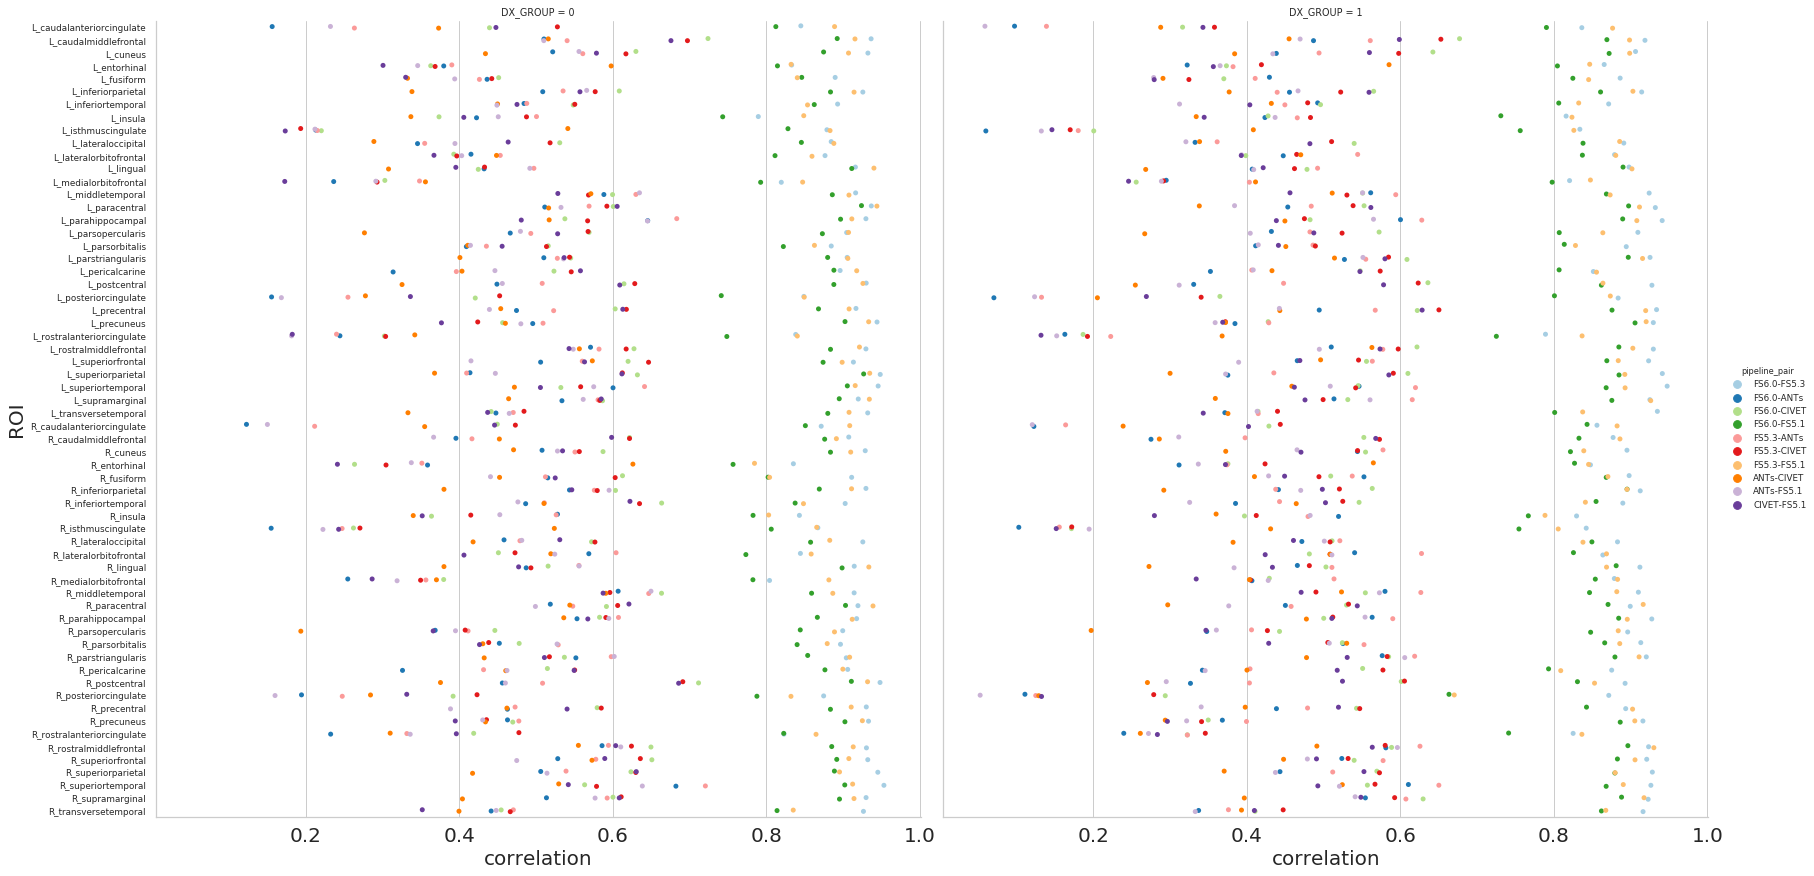

In [20]:
# Plot ROI wise correlations

plot_df = xcorr_pairs_df

print('Shape of cross-corr df {}, number of pairs {}'.format(xcorr_pairs_df.shape, len(xcorr_pairs_df['pipeline_pair'].unique())))
roi_order = sorted(list(xcorr_pairs_df['ROI'].unique()))
sns.set(font_scale=0.8)

with sns.axes_style("whitegrid"):
    g = sns.catplot(x='correlation',y='ROI',hue='pipeline_pair',order=roi_order,palette='Paired',col='DX_GROUP',
                data=plot_df,aspect=1,height=12,kind='strip')
    g.set_xticklabels(fontsize=20)
    g.set_xlabels(fontsize=20)
    g.set_ylabels(fontsize=20)

### Covariance / Correlation between ROIs

Shapes df (683, 63), df_corr (62, 62)


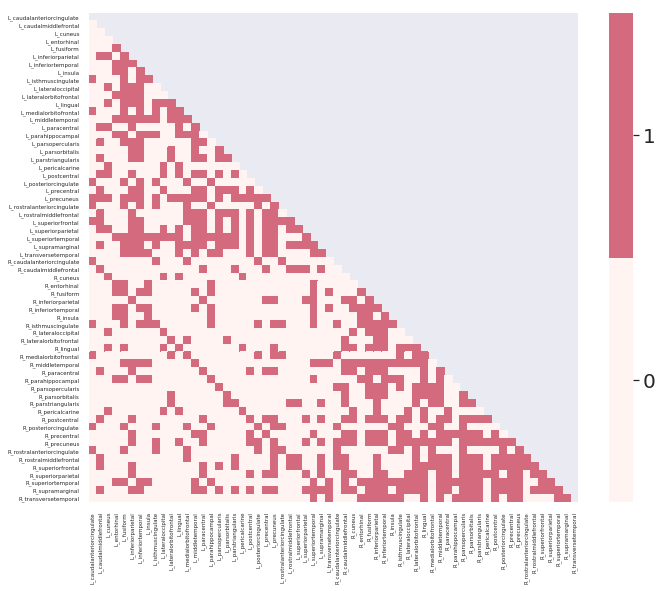

In [29]:
p_thresh= 0.05/(62*62/2) #Rough number of comparisons 
r_thresh = 0.5 #Look at only high correlations 

pipe = 'CIVET'
df = master_df[master_df['pipeline']==pipe][[subject_ID_col]+common_roi_cols]
df_sorted = df.reindex(sorted(df.columns), axis=1)

corr = df_sorted.corr()
df_p_val = calculate_pvalues(df_sorted)
corr[df_p_val >= p_thresh] = 0
corr[corr < r_thresh] = 0
print('Shapes df {}, df_corr {}'.format(df.shape,corr.shape))

# Plot
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))


# Generate a custom diverging colormap
cmap = sns.xkcd_palette(["very light pink",'pinkish']) #sns.diverging_palette(220, 10, as_cmap=True)

with sns.axes_style("white"):
    sns.set(font_scale=0.5)
    g = sns.heatmap(corr, mask=mask, cmap=cmap, square=True)
    colorbar = g.collections[0].colorbar
    colorbar.set_ticks([0.25,0.75])
    colorbar.set_ticklabels(['0', '1'])
    g.figure.axes[-1].tick_params(labelsize=20)

### Covariance / Correlation between Individuals

Shapes df (683, 63), df_corr (683, 683)


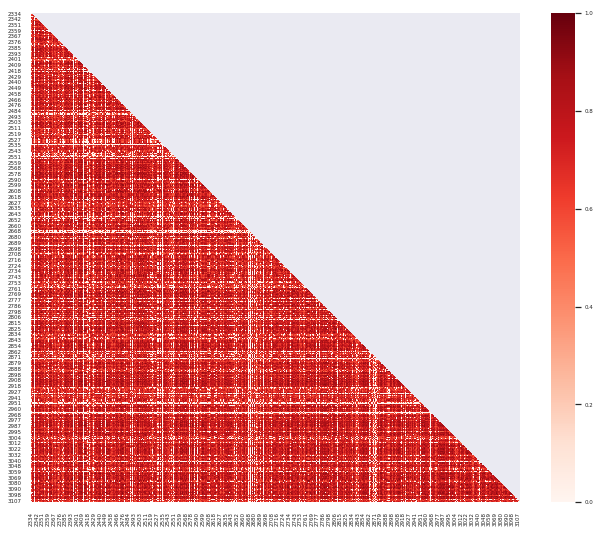

In [36]:
p_thresh= 0.05/(778*778/2) #Rough number of comparisons 
r_thresh = 0.5 #Look at only high correlations 

pipe = 'civet'
df = master_df[master_df['pipeline']==pipe][[subject_ID_col]+common_roi_cols]
df_sorted = df.reindex(sorted(df.columns), axis=1)

corr = df_sorted[common_roi_cols].transpose().corr()
df_p_val = calculate_pvalues(df_sorted)
corr[df_p_val >= p_thresh] = 0
corr[corr < r_thresh] = 0
print('Shapes df {}, df_corr {}'.format(df.shape,corr.shape))

# Plot
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = 'Reds'#sns.diverging_palette(220, 10, as_cmap=True)


with sns.axes_style("white"):
    sns.set(font_scale=0.5)
    g = sns.heatmap(corr, mask=mask, cmap=cmap, square=True)


### TSNE

In [55]:
from sklearn.manifold import TSNE
qc = 'auto'
master_df = master_df_dict[qc]

X = master_df[common_roi_cols].values
print(master_df.shape)

X_embedded = TSNE(n_components=2,init='pca').fit_transform(X)
X_embedded.shape

(3415, 68)


(3415, 2)

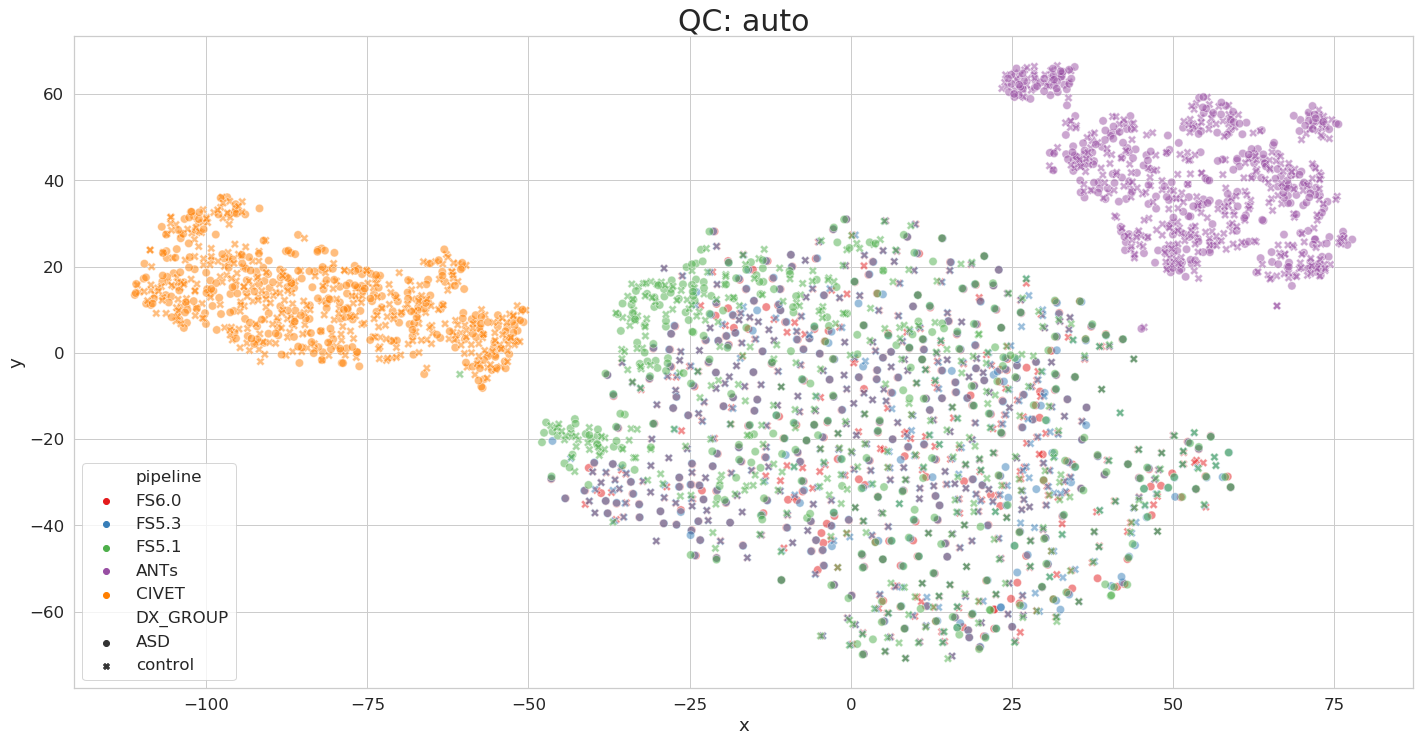

In [56]:
# plot
embed_df = pd.DataFrame(columns=['x','y'],data=X_embedded)
embed_df['pipeline'] = master_df['pipeline'].values
embed_df['DX_GROUP'] = master_df['DX_GROUP'].values
embed_df['DX_GROUP'] = embed_df['DX_GROUP'].replace({0:'control', 1:'ASD'})

plt.figure(figsize=(24,12))
sns.set(font_scale=1.52) 
hue_order = ['FS6.0','FS5.3','FS5.1','ANTs','CIVET']
with sns.axes_style("whitegrid"):
    g = sns.scatterplot(x='x',y='y',hue='pipeline',hue_order=hue_order, style='DX_GROUP', s=70, alpha=0.5,
                    data=embed_df,palette="Set1")
    g.legend(loc=3)
    plt.title('QC: {}'.format(qc),fontsize=30)
    #g.figure.savefig('/Users/nikhil/Desktop/tsne.png', dpi=300)

### Subject clustering

Pipeline: FS6.0
Pipeline: FS5.3
Pipeline: ANTs
Pipeline: CIVET
Pipeline: FS5.1


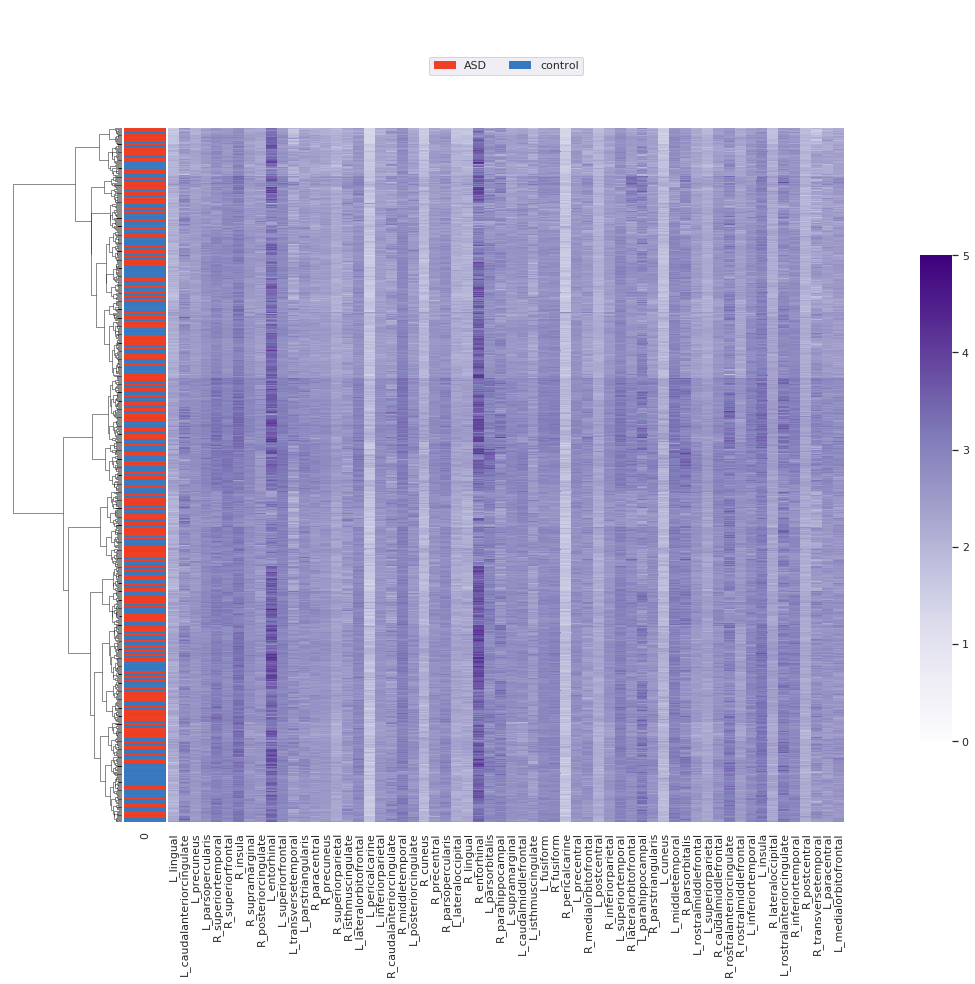

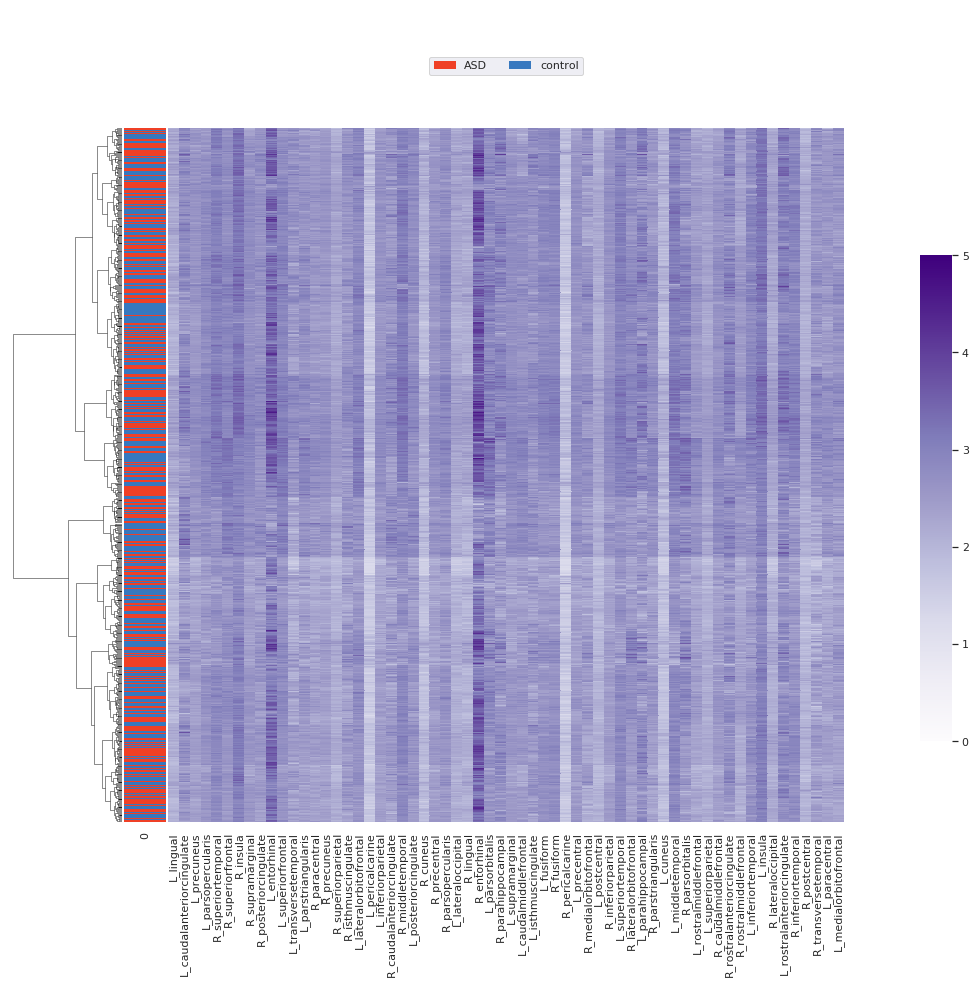

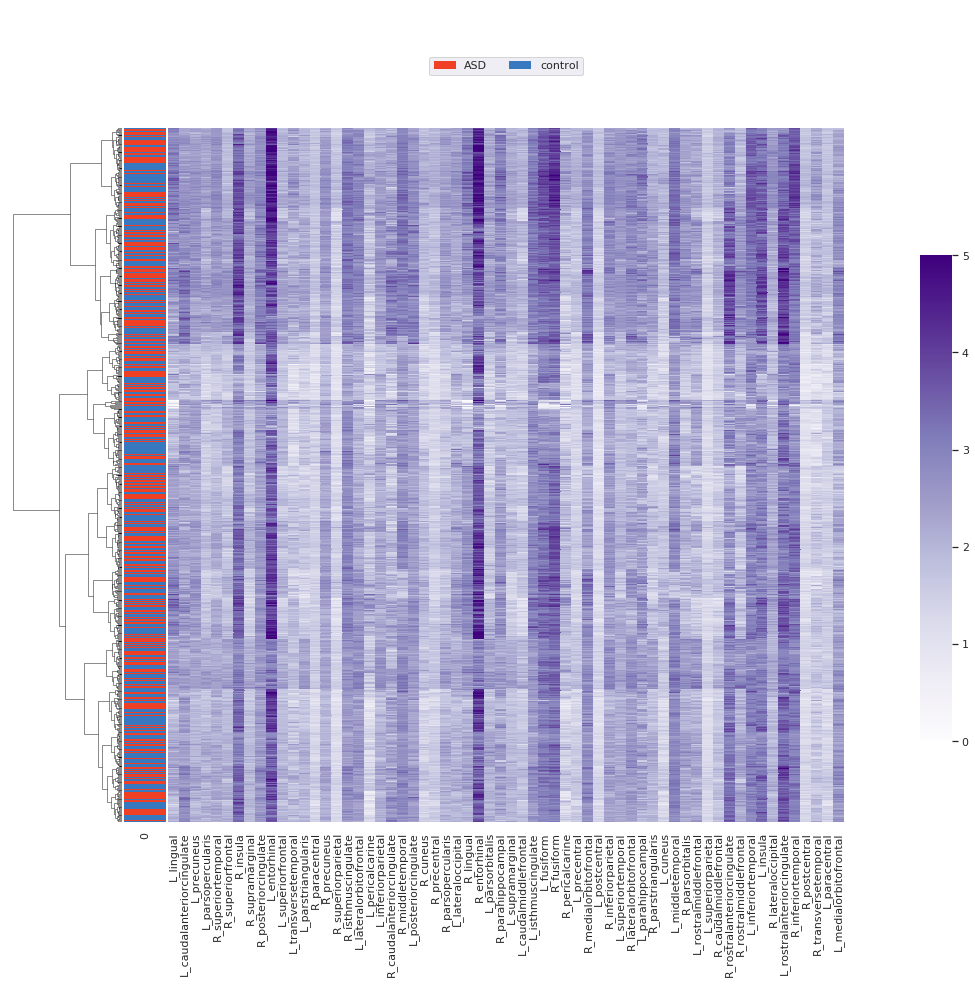

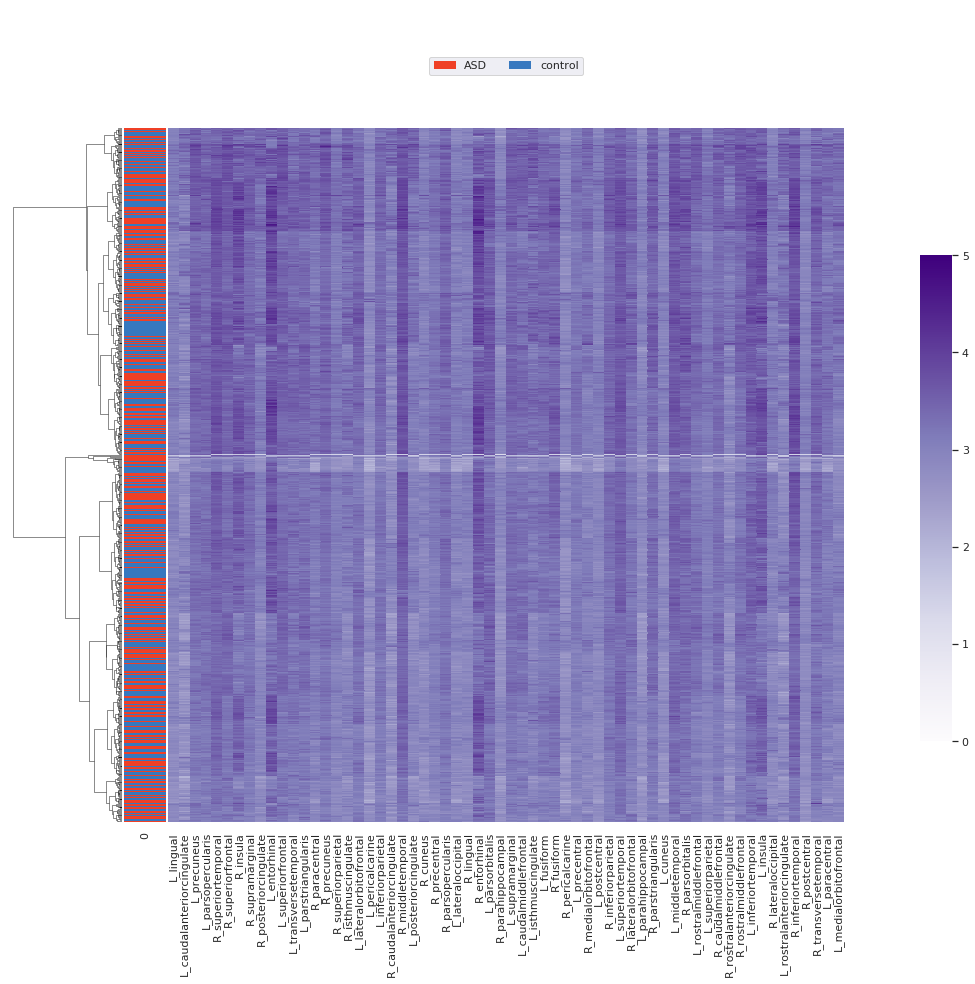

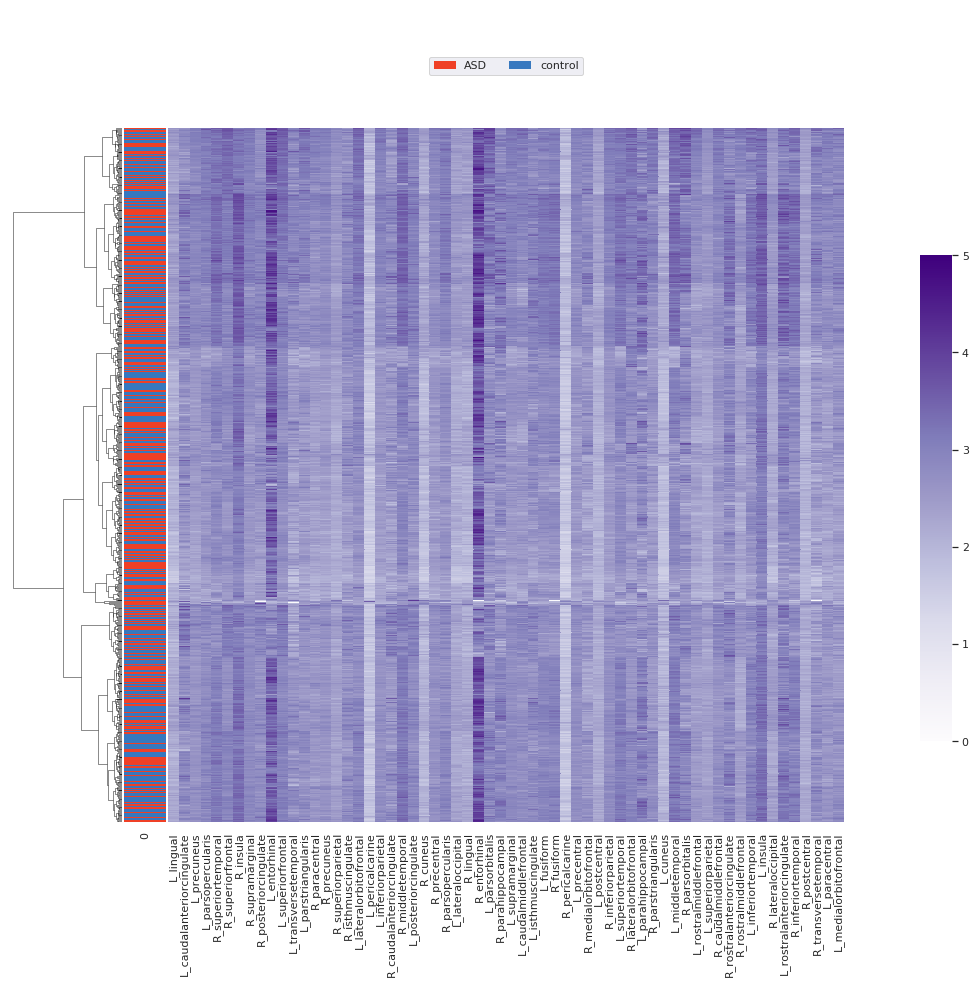

In [95]:
qc = 'No_QC'
master_df = master_df_dict[qc]

similarity = 'euclidean'#'euclidean' #correlation
linkage = 'ward'

# colors for the Dx visuals
colors = ["tomato","windows blue"]
Dx_palette = sns.xkcd_palette(colors)

sns.set(style="white")
sns.set(font_scale=1)

# Generate a custom diverging colormap
cmap = 'Purples' #sns.cubehelix_palette()#sns.diverging_palette(220, 10, as_cmap=True)

# create clustermap list for calculating overlap later
clustermap_dict = {} 

for pipe in master_df['pipeline'].unique():
    print('Pipeline: {}'.format(pipe))
    cluster_df = master_df[master_df['pipeline']==pipe].copy().reset_index(drop=True)
    cluster_df['DX_GROUP'] = cluster_df['DX_GROUP'].replace({0:'control', 1:'ASD'})
    labels = cluster_df['DX_GROUP'].values
    lut = dict(zip(set(labels), Dx_palette))
    row_colors = pd.DataFrame(labels)[0].map(lut)

    
    g = sns.clustermap(cluster_df[common_roi_cols], row_cluster=True, col_cluster=False, metric = similarity, method=linkage, 
                       cmap=cmap,figsize=(15, 15),xticklabels=True, yticklabels=False,row_colors=row_colors,
                       vmin=0, vmax=5,)
    # Draw the legend bar for the classes                 
    for label in set(labels):
        g.ax_col_dendrogram.bar(0, 0, color=lut[label],label=label, linewidth=0)

    g.ax_col_dendrogram.legend(loc="center", ncol=2)
    g.cax.set_position([.97, .2, .03, .45])

    clustermap_dict[pipe] = g

In [97]:
# Pairwise subject cluster membership across pipelines

n_cluster = 2
# Generate dataframe with subject-cluster membership for all pipelines
# This needs to be aligned by SubjID
member_df_concat = pd.DataFrame()
for p, pipe in enumerate(clustermap_dict.keys()):
    member_df = get_cluster_membership(master_df[master_df['pipeline']==pipe], clustermap_dict[pipe], n_cluster)
    if p == 0:
        member_df_concat = member_df
    else:
        member_df_concat = pd.merge(member_df_concat, member_df, on='SubjID',how='inner')
        
# Compare pipeline pairs for consistancy on subject-pairs memberships
# e.g. a pair of subjects that belongs to same cluster in pipeline A should ideally be in the same cluster for pipeline B
possible_pairs = list(itertools.combinations(clustermap_dict.keys(), 2))
for pair in possible_pairs:
    pipe1 = pair[0]
    pipe2 = pair[1]
    m_col1 = 'membership_{}'.format(pipe1)
    m_col2 = 'membership_{}'.format(pipe2)
    c_membership1 = generate_pairwise_membership(member_df_concat,m_col1)
    c_membership2 = generate_pairwise_membership(member_df_concat,m_col2)
    pairwise_membership_consistancy = c_membership1.values == c_membership2.values
    n_unique_pairs = len(pairwise_membership_consistancy.flatten())/2-pairwise_membership_consistancy.shape[0]
    overlap = np.triu(pairwise_membership_consistancy).sum()/n_unique_pairs
    print('\ncluster membership overlap: {} {:3.2f}'.format(pair, overlap))

Pipeline FS6.0, cluster sizes Counter({2: 497, 1: 281})
Pipeline FS5.3, cluster sizes Counter({1: 414, 2: 364})
Pipeline ANTs, cluster sizes Counter({2: 535, 1: 243})
Pipeline CIVET, cluster sizes Counter({2: 412, 1: 366})
Pipeline FS5.1, cluster sizes Counter({2: 533, 1: 245})

cluster membership overlap: ('FS6.0', 'FS5.3') 0.71

cluster membership overlap: ('FS6.0', 'ANTs') 0.50

cluster membership overlap: ('FS6.0', 'CIVET') 0.56

cluster membership overlap: ('FS6.0', 'FS5.1') 0.56

cluster membership overlap: ('FS5.3', 'ANTs') 0.53

cluster membership overlap: ('FS5.3', 'CIVET') 0.54

cluster membership overlap: ('FS5.3', 'FS5.1') 0.64

cluster membership overlap: ('ANTs', 'CIVET') 0.55

cluster membership overlap: ('ANTs', 'FS5.1') 0.52

cluster membership overlap: ('CIVET', 'FS5.1') 0.52


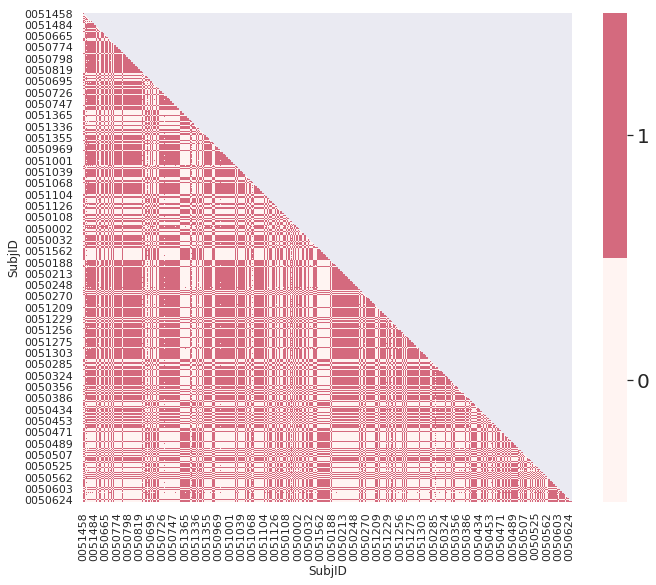

In [14]:
# Plot subject-pairs heatmap
m_col = 'membership_fs60'
c_membership = generate_pairwise_membership(member_df_concat,m_col)

# Generate a mask for the upper triangle
mask = np.zeros_like(c_membership, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.xkcd_palette(["very light pink",'pinkish']) #sns.diverging_palette(220, 10, as_cmap=True)

with sns.axes_style("white"):
    sns.set(font_scale=0.5)
    g = sns.heatmap(c_membership, mask=mask, cmap=cmap, square=True)
    colorbar = g.collections[0].colorbar
    colorbar.set_ticks([0.25,0.75])
    colorbar.set_ticklabels(['0', '1'])
    g.figure.axes[-1].tick_params(labelsize=20)

### CCA between cortical "representations"

In [15]:
from sklearn.cross_decomposition import CCA

sim_df_concat = pd.DataFrame()
for qc in master_df_dict.keys():
    master_df = master_df_dict[qc]
    for p, pair in enumerate(possible_pairs):
        pipe1 = pair[0]
        pipe2 = pair[1]
        X = master_df[master_df['pipeline']==pipe1][common_roi_cols].values
        Y = master_df[master_df['pipeline']==pipe2][common_roi_cols].values

        n_components = 10
        cca = CCA(n_components=n_components,scale=True)
        cca.fit(X, Y)
        X_c, Y_c = cca.transform(X, Y)
        corr_list = []
        for c in range(n_components):
            corr = np.corrcoef(X_c[:,c].flatten(),Y_c[:,c].flatten())[0,1]
            corr_list.append(np.round(corr,3))

        sim_df = pd.DataFrame(columns=['pair','cca_corr','qc_type'])
        sim_df.loc[p] = ['{}_{}'.format(pair[0],pair[1]),np.mean(corr_list),qc]

        sim_df_concat = sim_df_concat.append(sim_df)
        #print('{} {} correlation {}'.format(pipe1, pipe2, np.mean(corr_list)))
    
    

/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


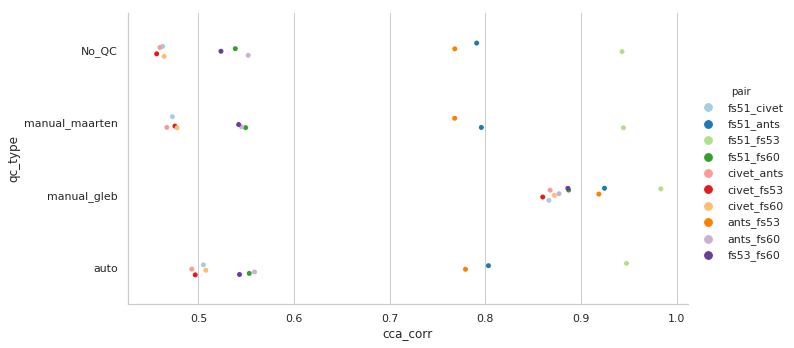

In [16]:
plot_df = sim_df_concat
sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='cca_corr',y='qc_type',hue='pair',palette='Paired',
                data=plot_df,aspect=2,height=5,kind='strip')

In [17]:
# See the effect of sample size from No_QC dataset
sim_df_concat_samp = pd.DataFrame()
n_sampx = np.arange(100,800,100)
n_components = 10
for p, pair in enumerate(possible_pairs):
    pipe1 = pair[0]
    pipe2 = pair[1]
    X = master_df[master_df['pipeline']==pipe1][common_roi_cols].values
    Y = master_df[master_df['pipeline']==pipe2][common_roi_cols].values

    for n in n_sampx:
        qc_type = 'RS_{}'.format(n)
        sample_rows = np.random.randint(len(X),size=n)
        X_samp = X[sample_rows]
        Y_samp = Y[sample_rows]
        cca = CCA(n_components=n_components,scale=True)
        cca.fit(X_samp, Y_samp)
        X_c, Y_c = cca.transform(X_samp, Y_samp)
        
        # compute correlation for multiple canonical components
        corr_list = []
        for c in range(n_components):
            corr = np.corrcoef(X_c[:,c].flatten(),Y_c[:,c].flatten())[0,1]
            corr_list.append(np.round(corr,3))
        
        sim_df = pd.DataFrame(columns=['pair','cca_corr','qc_type'])
        sim_df.loc[p] = ['{}_{}'.format(pair[0],pair[1]),np.mean(corr_list),qc_type]

        sim_df_concat_samp = sim_df_concat_samp.append(sim_df)
        #print('{} {} correlation {:4.2f}'.format(pipe1, pipe2, np.mean(corr_list)))

/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-

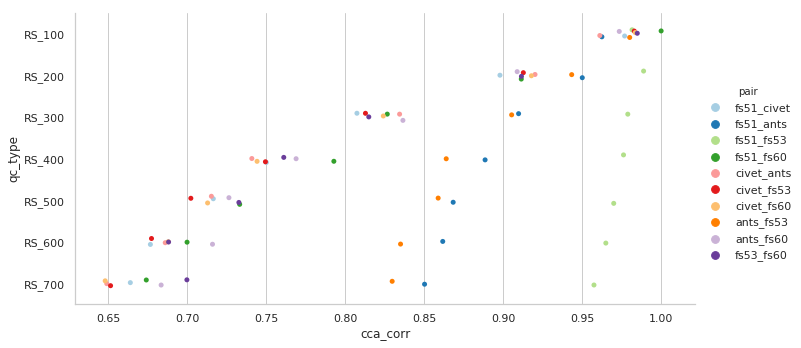

In [18]:
plot_df = sim_df_concat_samp #.sort_values(by='corr')
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='cca_corr',y='qc_type',hue='pair',palette='Paired',
                data=plot_df,aspect=2,height=5,kind='strip')

### Compare ML performance 

In [89]:
ml_results_dir = results_dir + 'ml/'

# Start time
start = time.time()

save_perf = True
rank_features = True
model_type = 'regression'
cv_type = 'shuffle_split'
ml_perf_concat = pd.DataFrame()
feature_rank_df_concat = pd.DataFrame()

for qc in qc_list:
    master_df = master_df_dict[qc]
    roi_cols = common_roi_cols

    if model_type.lower() == 'regression':
        for dx_grp in [0,1]:
            print('\nUsing qc {}, and Dx {}'.format(qc,dx_grp))
            ml_master_df = master_df[master_df['DX_GROUP']==dx_grp]
            outcome_col = 'AGE_AT_SCAN'
            covar_continuous_cols = []
            covar_cat_cols = ['SEX','SITE_ID'] 
            model = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=50)
            ml_perf,perf_pval_dict,feature_rank_df = computePipelineMLModels(ml_master_df,roi_cols,covar_continuous_cols,
                                                                             covar_cat_cols,outcome_col,model_type,model,
                                                                             rank_features,n_jobs=-1)

            ml_perf['DX_GROUP'] = np.tile(dx_grp,len(ml_perf))
            ml_perf['qc'] = np.tile(qc,len(ml_perf))
            ml_perf_concat = ml_perf_concat.append(ml_perf)
            
            feature_rank_df['DX_GROUP'] = np.tile(dx_grp,len(feature_rank_df))
            feature_rank_df['qc'] = np.tile(qc,len(feature_rank_df))            
            feature_rank_df_concat = feature_rank_df_concat.append(feature_rank_df)
        
    else: 
        print('\nUsing qc {}'.format(qc))
        ml_master_df = master_df

        outcome_col = 'DX_GROUP'
        covar_continuous_cols = ['AGE_AT_SCAN']
        covar_cat_cols = ['SEX','SITE_ID'] 
        #model = svm.SVC(kernel='linear')
        model = RandomForestClassifier(n_estimators=50, max_depth=2,random_state=0)

        ml_perf,perf_pval_dict,feature_rank_df = computePipelineMLModels(ml_master_df,roi_cols,covar_continuous_cols,covar_cat_cols,
                                                     outcome_col,model_type,model,n_jobs=-1)

        ml_perf['qc'] = np.tile(qc,len(ml_perf))
        ml_perf_concat = ml_perf_concat.append(ml_perf)
        
        feature_rank_df['DX_GROUP'] = np.tile(dx_grp,len(feature_rank_df))
        feature_rank_df['qc'] = np.tile(qc,len(feature_rank_df))            
        feature_rank_df_concat = feature_rank_df_concat.append(feature_rank_df)
        
if save_perf:
    save_path = '{}pipelines_ml_feature_imp_{}_{}_{}.pkl'.format(ml_results_dir,outcome_col,model_type,cv_type)
    print('Saving sm_perf dictionary at \n{}'.format(save_path))
    save_df = feature_rank_df_concat[(feature_rank_df_concat['predictor'].isin(roi_cols))]
    save_df = save_df.rename(columns={'predictor':'roi'})
    save_df.to_pickle(save_path)
        
    
end = time.time()
print('Run duration:')
print((end - start)/60.0)


Using qc No_QC, and Dx 0
Running ML classifer on 5 pipelines
Pipeline FS6.0
Using ['SEX', 'SITE_ID'] categorical cols as 19 cat covar (dummies)
n of input columns: 81
Data shapes X (415, 81), y 415 (17.86m, 7.72sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-37.490, sd:12.916
Pipeline FS5.3
Using ['SEX', 'SITE_ID'] categorical cols as 19 cat covar (dummies)
n of input columns: 81
Data shapes X (415, 81), y 415 (17.86m, 7.72sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-31.462, sd:8.935
Pipeline ANTs
Using ['SEX', 'SITE_ID'] categorical cols as 19 cat covar (dummies)
n of input columns: 81
Data shapes X (415, 81), y 415 (17.86m, 7.72sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-36.129, sd:10.415
Pipeline CIVET
Using ['SEX', 'SITE_ID'] categorical cols as 19 cat covar (dummies)
n of input columns: 81
Data shapes X (415, 81), y 415 (17.86m, 7.72sd)
Using regression model with perf metric neg_m

 Perf mean:-16.907, sd:4.142
Pipeline ANTs
Using ['SEX', 'SITE_ID'] categorical cols as 18 cat covar (dummies)
n of input columns: 80
Data shapes X (371, 80), y 371 (16.25m, 5.47sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-20.777, sd:4.877
Pipeline CIVET
Using ['SEX', 'SITE_ID'] categorical cols as 18 cat covar (dummies)
n of input columns: 80
Data shapes X (371, 80), y 371 (16.25m, 5.47sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-22.062, sd:5.095
Pipeline FS5.1
Using ['SEX', 'SITE_ID'] categorical cols as 18 cat covar (dummies)
n of input columns: 80
Data shapes X (371, 80), y 371 (16.25m, 5.47sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-16.713, sd:4.774

Using qc auto, and Dx 1
Running ML classifer on 5 pipelines
Pipeline FS6.0
Using ['SEX', 'SITE_ID'] categorical cols as 18 cat covar (dummies)
n of input columns: 80
Data shapes X (312, 80), y 312 (15.87m, 5.08sd)
Using regression mo

{'FS6.0': 0.09090909090909091, 'FS5.3': 0.09090909090909091, 'ANTs': 0.09090909090909091, 'CIVET': 0.09090909090909091, 'FS5.1': 0.09090909090909091}


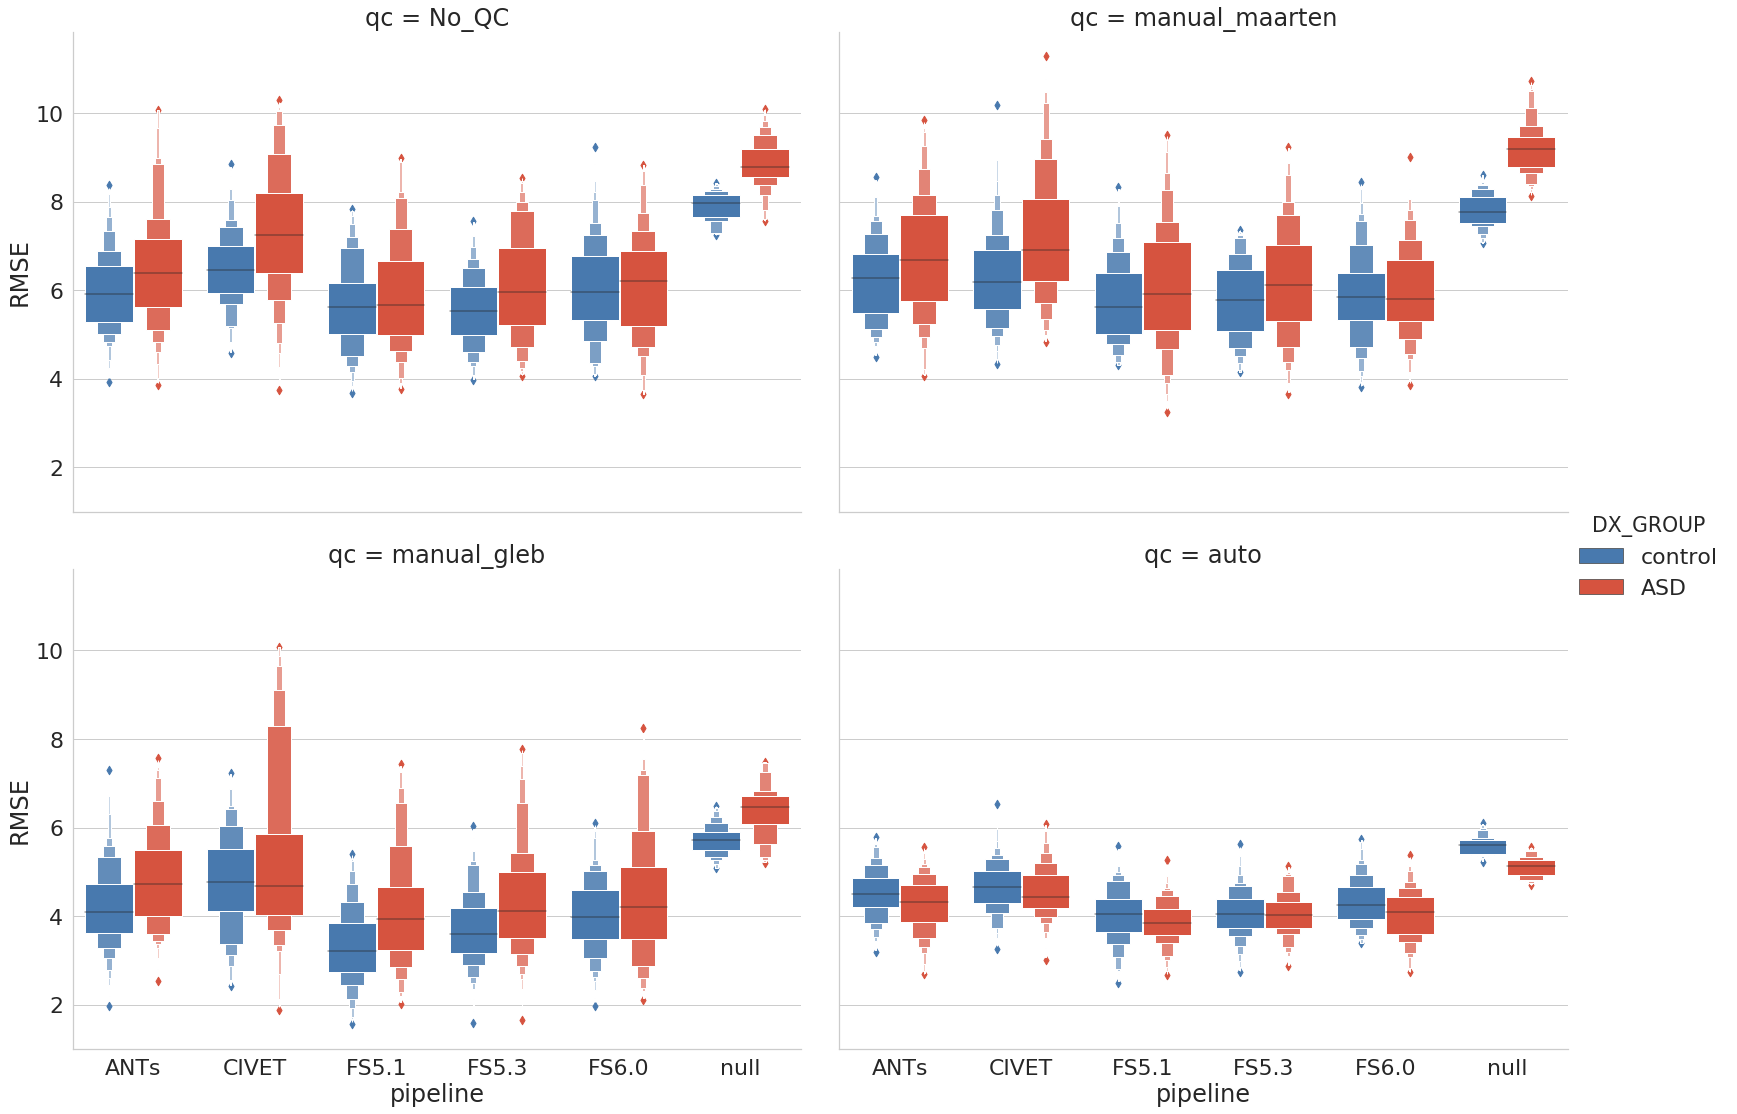

In [90]:
# plot ML performance
print(perf_pval_dict)
x_order = ['ANTs','CIVET','FS5.1','FS5.3','FS6.0','null']
col_order = ['No_QC','manual_maarten','manual_gleb','auto']
colors = ["windows blue", "tomato", "greyish", "faded green", "dusty purple","dark grey"]
palette = sns.xkcd_palette(colors) #'Paired' #sns.xkcd_palette(colors)
sns.set(font_scale=2)
    
plot_df = ml_perf_concat.copy()

if model_type.lower() == 'regression':
    plot_df['RMSE'] = np.sqrt(-1*plot_df['neg_mean_squared_error'])
    plot_df['DX_GROUP'] = plot_df['DX_GROUP'].replace({0:'control', 1:'ASD'})

    with sns.axes_style("whitegrid"): 
        g = sns.catplot(y='RMSE',x='pipeline', hue='DX_GROUP', kind='boxen',col='qc',col_order=col_order,col_wrap=2,
                        order=x_order,palette=palette,height=8, aspect=1.4,legend=True,data=plot_df)
        #plt.legend(loc='upper right')
else:
    with sns.axes_style("white"): 
        g = sns.catplot(y='roc_auc',x='pipeline', hue='DX_GROUP', kind='boxen',data=plot_df,col='qc',col_order=col_order,
                        order=x_order,palette=palette,height=20, aspect=1.1,legend=False)
#         plt.legend(loc='upper right')

### Get ML based feature importance

In [101]:
feature_count_df = pd.DataFrame(columns=['count','pipeline','DX_GROUP','qc'])
i = 0
roi_cols = common_roi_cols
for pipe in ml_master_df['pipeline'].unique():
    for qc in feature_rank_df_concat['qc'].unique():
        for dx in [0,1]:
            n_feat = len(feature_rank_df_concat[(feature_rank_df_concat['pipeline'] == pipe) &                              
                                                (feature_rank_df_concat['rank'] == 1) &                              
                                                (feature_rank_df_concat['predictor'].isin(roi_cols)) & 
                                                (feature_rank_df_concat['qc'] == qc) &
                                                (feature_rank_df_concat['DX_GROUP'] == dx)])
            feature_count_df.loc[i] = [n_feat,pipe,dx,qc]
            i+=1
            print('Pipeline {}, n_roi {}, qc {}, dx {}, n_feat {}\n'.format(pipe,len(roi_cols),qc,dx,n_feat))

Pipeline FS6.0, n_roi 62, qc No_QC, dx 0, n_feat 19

Pipeline FS6.0, n_roi 62, qc No_QC, dx 1, n_feat 17

Pipeline FS6.0, n_roi 62, qc manual_maarten, dx 0, n_feat 43

Pipeline FS6.0, n_roi 62, qc manual_maarten, dx 1, n_feat 53

Pipeline FS6.0, n_roi 62, qc manual_gleb, dx 0, n_feat 23

Pipeline FS6.0, n_roi 62, qc manual_gleb, dx 1, n_feat 24

Pipeline FS6.0, n_roi 62, qc auto, dx 0, n_feat 22

Pipeline FS6.0, n_roi 62, qc auto, dx 1, n_feat 30

Pipeline FS5.3, n_roi 62, qc No_QC, dx 0, n_feat 5

Pipeline FS5.3, n_roi 62, qc No_QC, dx 1, n_feat 21

Pipeline FS5.3, n_roi 62, qc manual_maarten, dx 0, n_feat 4

Pipeline FS5.3, n_roi 62, qc manual_maarten, dx 1, n_feat 15

Pipeline FS5.3, n_roi 62, qc manual_gleb, dx 0, n_feat 20

Pipeline FS5.3, n_roi 62, qc manual_gleb, dx 1, n_feat 36

Pipeline FS5.3, n_roi 62, qc auto, dx 0, n_feat 57

Pipeline FS5.3, n_roi 62, qc auto, dx 1, n_feat 23

Pipeline ANTs, n_roi 62, qc No_QC, dx 0, n_feat 13

Pipeline ANTs, n_roi 62, qc No_QC, dx 1, n_fea

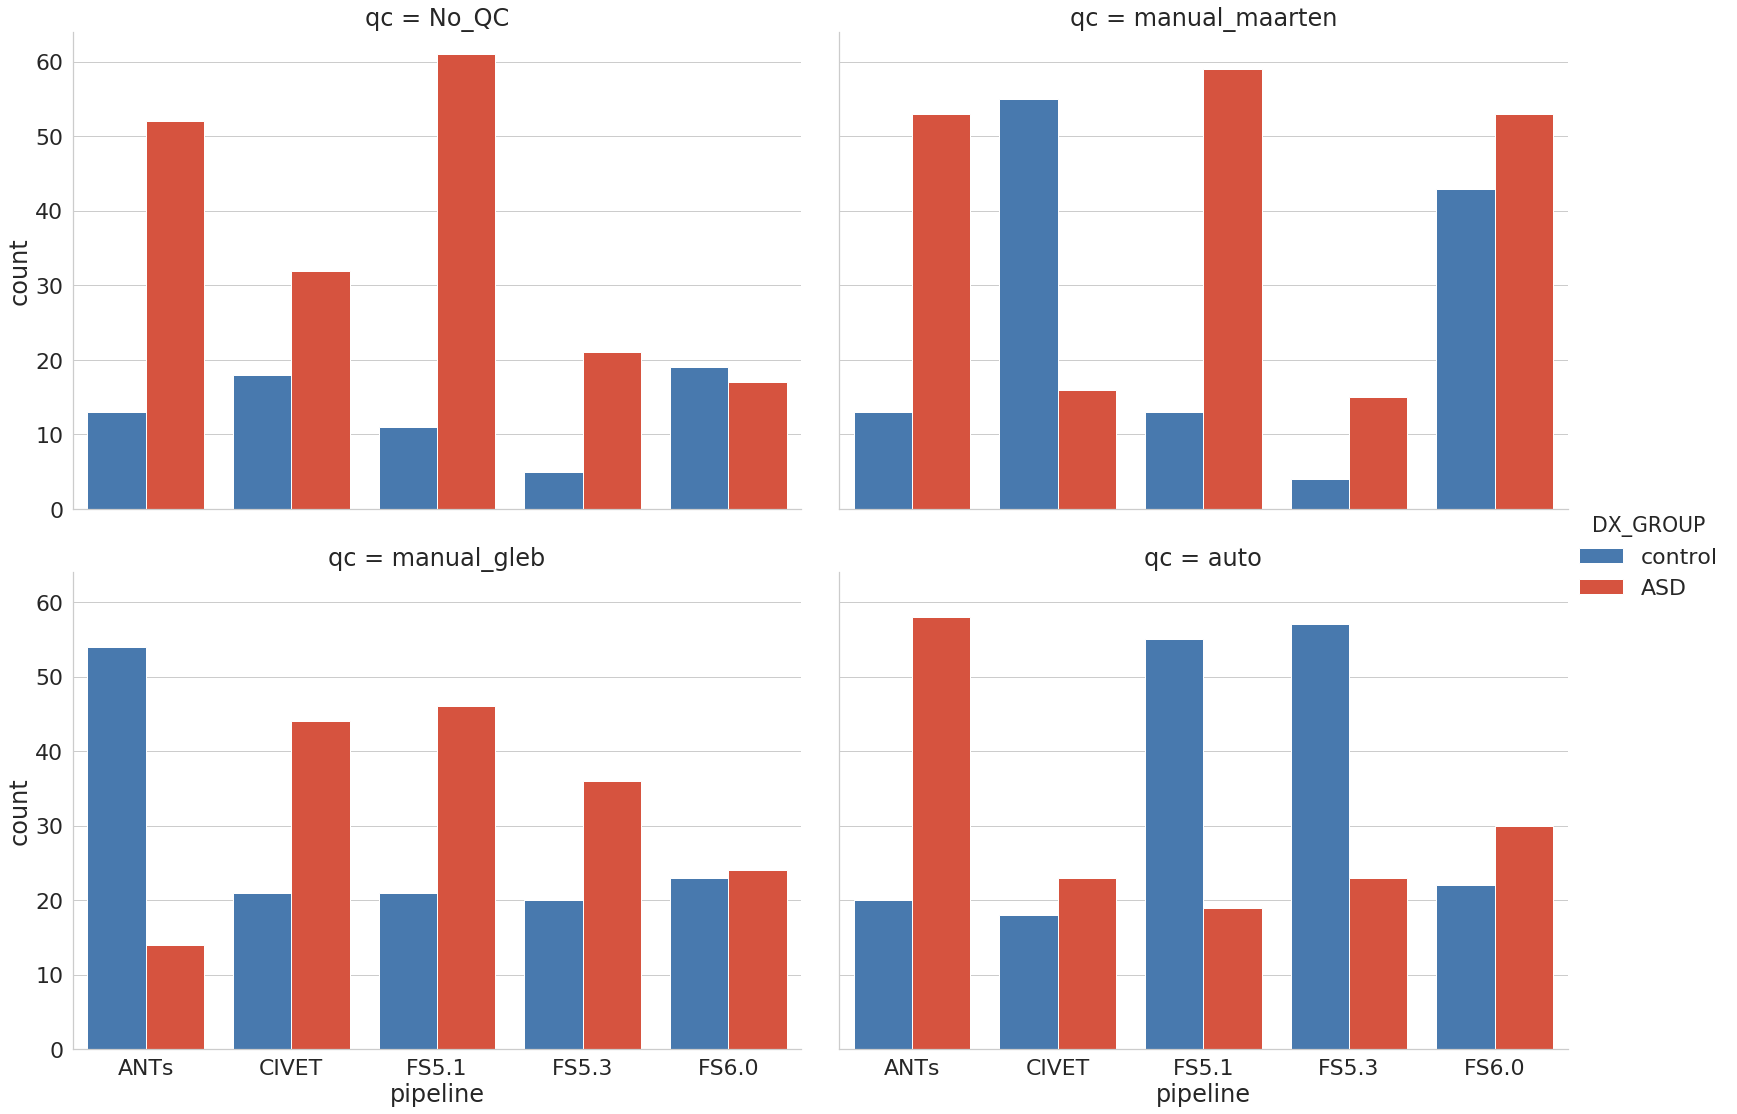

In [105]:
plot_df = feature_count_df
plot_df = plot_df #[plot_df['qc']=='No_QC']
plot_df['DX_GROUP'] = plot_df['DX_GROUP'].replace({0:'control', 1:'ASD'})
sns.set(font_scale=2)

with sns.axes_style("whitegrid"): 
    x_order = ['ANTs','CIVET','FS5.1','FS5.3','FS6.0']
    g = sns.catplot(y='count',x='pipeline',hue='DX_GROUP', col='qc', col_wrap=2,
                    kind='bar', palette=palette, height=8, aspect=1.4, data=plot_df, order=x_order)


### Compare statsmodels performance 
- statmodels performance plots are generate using "generate_plots" notebook

In [16]:
save_sm_perf = False
sm_results_dir = results_dir + 'sm/'

model_type = 'ols'
if model_type == 'ols':
    covar_cols = [('DX_GROUP','cat'),('SEX','cat'),('SITE_ID','cat')]
    outcome_col = ('AGE_AT_SCAN','continuous')
    signific_col = ('roi','continuous')
    stat_model = 'ols' 
elif model_type == 'logit':
    covar_cols = [('AGE_AT_SCAN','continuous'),('SEX','cat'),('SITE_ID','cat')]
    outcome_col = ('DX_GROUP','cat') 
    signific_col = ('roi','continuous') 
    stat_model = 'logit' 
else:
    print('unknown stat model')

roi_cols = common_roi_cols

for qc in qc_list:
    print('QC type {}'.format(qc))
    master_df = master_df_dict[qc]
    sm_perf = computePipelineStatsModels(master_df,roi_cols,covar_cols,outcome_col,signific_col,stat_model)
    print('Shape of the stats_models results df {}'.format(sm_perf.shape))
    filtered_subs = master_df[subject_ID_col].unique()
    if save_sm_perf:
        save_path = '{}pipelines_sm_perf_{}_{}_{}_QC_{}_N_{}.pkl'.format(sm_results_dir,outcome_col[0],signific_col[0],
                                                                         stat_model,qc,len(filtered_subs))
        print('Saving sm_perf dictionary at \n{}'.format(save_path))
        sm_perf.to_pickle(save_path)


QC type No_QC
Running 62 mass-univariate ols statsmodels on 5 pipelines
Pipeline FS5.1
Example statsmodel run:
 AGE_AT_SCAN ~ R_superiorfrontal + C(DX_GROUP) + C(SEX) + C(SITE_ID)
Top 10 significant regions:
                        roi       coef      t_val         p_val    p_val_corr  \
23             R_precuneus -18.200013 -18.871232  2.136281e-65  1.324494e-63   
52             L_precuneus -17.013260 -18.043898  8.244529e-61  2.555804e-59   
46      R_inferiorparietal -16.437928 -17.130954  7.617916e-56  1.574369e-54   
4       L_inferiorparietal -15.118837 -16.768897  6.613476e-54  1.025089e-52   
33  L_lateralorbitofrontal -13.531330 -15.790194  9.204867e-49  1.075086e-47   
48       L_superiorfrontal -14.214253 -15.779923  1.040406e-48  1.075086e-47   
55  R_rostralmiddlefrontal -14.345453 -15.404160  8.932259e-47  7.911429e-46   
61       R_superiorfrontal -13.434887 -15.071159  4.410937e-45  3.418476e-44   
11      R_superiorparietal -15.649553 -15.008239  9.169389e-45  5.70616

Example statsmodel run:
 AGE_AT_SCAN ~ R_superiorfrontal + C(DX_GROUP) + C(SEX) + C(SITE_ID)
Top 10 significant regions:
                        roi       coef      t_val         p_val    p_val_corr  \
23             R_precuneus -19.211044 -16.855272  4.679960e-54  2.901575e-52   
52             L_precuneus -18.183585 -16.180966  1.584874e-50  4.913111e-49   
48       L_superiorfrontal -15.532178 -15.043415  9.965159e-45  2.059466e-43   
4       L_inferiorparietal -16.887879 -14.878906  6.597242e-44  1.022572e-42   
61       R_superiorfrontal -15.212202 -14.373387  2.049913e-41  2.541893e-40   
55  R_rostralmiddlefrontal -15.910121 -14.341214  2.942927e-41  3.041025e-40   
11      R_superiorparietal -17.573279 -14.118412  3.556014e-40  3.149612e-39   
46      R_inferiorparietal -16.514239 -14.031177  9.377827e-40  7.267816e-39   
49  L_rostralmiddlefrontal -14.515444 -13.687824  4.122986e-38  2.840279e-37   
53         L_supramarginal -15.496733 -13.624756  8.212418e-38  5.091699e-37  

Example statsmodel run:
 AGE_AT_SCAN ~ R_superiorfrontal + C(DX_GROUP) + C(SEX) + C(SITE_ID)
Top 10 significant regions:
                        roi      coef     t_val     p_val  p_val_corr pipeline
55  R_rostralmiddlefrontal -6.462883 -4.169461  0.000047    0.002932    CIVET
49  L_rostralmiddlefrontal -6.189852 -3.827839  0.000178    0.005516    CIVET
33  L_lateralorbitofrontal -5.202538 -3.363595  0.000939    0.019406    CIVET
60      L_superiorparietal -5.388331 -3.081305  0.002383    0.036935    CIVET
4       L_inferiorparietal -5.271966 -2.973199  0.003349    0.039534    CIVET
57      L_parstriangularis -4.757366 -2.881523  0.004436    0.039534    CIVET
41  R_lateralorbitofrontal -4.470023 -2.839982  0.005028    0.039534    CIVET
61       R_superiorfrontal -4.822909 -2.835176  0.005101    0.039534    CIVET
45   L_caudalmiddlefrontal -4.148055 -2.752015  0.006526    0.044156    CIVET
12           R_paracentral -4.634387 -2.704307  0.007498    0.044156    CIVET
Shape of the stats_m